In [1]:
import pickle
from brokenaxes import brokenaxes
import numpy as np
import pandas as pd
import itertools as it
from pathlib import Path
import matplotlib.pylab as plt
from lameg.util import get_files, make_directory, check_many
import nibabel as nib
from scipy.spatial.distance import euclidean
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from copy import copy

In [2]:
plt.rcParams.update({
    'font.size': 16,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

In [3]:
def add_subplot_label(ax, label, x=-.21, y=1.225):
    ax.text(x, y, label,  # Adjust left of y-axis
            transform=ax.transAxes,
            fontsize=26, va='top', ha='right')


In [4]:
n_layers = 11
layers = np.arange(n_layers)
vx_loc, vx_adj, surf_norm = nib.load(Path("/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/surf/multilayer.11.ds.link_vector.fixed.gii")).agg_data()
layers_loc = np.array(np.split(vx_loc, n_layers, axis=0))
cortical_thickness = np.array([euclidean(layers_loc[0, i, :], layers_loc[-1, i, :]) for i in range(layers_loc.shape[1])])

In [5]:
coreg_res = Path("../output/coreg_err_simulations/")
coreg_files = get_files(coreg_res, "*.pickle")

In [6]:
def annotate_mx(im, txt_mx, **textkw):
    kw = dict(
        horizontalalignment="center",
        verticalalignment="center"
    )
    kw.update(textkw)
    for r, c in it.product(range(txt_mx.shape[0]), range(txt_mx.shape[1])):
        im.axes.text(c, r, txt_mx[r, c], **kw)

def colorbar(mappable, label):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label=label)
    plt.sca(last_axes)
    return cbar


def plot_mx(mx, title="", ax=False, labels=False, cbar=False, cmap="Spectral_r", norm=False, cbar_label=r"$\Delta$ FE"):
    if not ax:
        f, ax = plt.subplots(1, 1)
    else:
        ax = ax
    if not norm:
        iw = ax.imshow(mx, cmap=cmap)
    else:
        iw = ax.imshow(mx, cmap=cmap, norm=norm)
    if labels:
        ax.set_ylabel("Evaluation")
        ax.set_xlabel("Simulation")
        ax.set_xticks([0,n_layers-1])
        ax.set_xticklabels(['S','D'])
        ax.set_yticks([0,n_layers-1])
        ax.set_yticklabels(['S','D'])
        plt.suptitle(title)
        plt.tight_layout()
    if cbar:
        colorbar(iw, cbar_label)
    return iw


def norm_res(mx):
    norm = np.zeros(mx.shape)
    for l in range(mx.shape[1]):
        normed = mx[:,l] - np.min(mx[:,l])
        norm[:,l] = normed
    return norm


def find_peaks(mx, marker="*", return_annot=True):
    annot = np.zeros(mx.shape).astype(np.object_)
    peaks = []
    for l in range(mx.shape[1]):
        peak = np.argmax(mx[:, l]) # here is the problem (you find peak in evaluated!)
        annot[peak,l] = 1.0
        peaks.append(peak)
    peaks = np.array(peaks)
    annot_bin = np.copy(annot).astype(float)
    annot[annot==0.0] = None
    annot[annot==1.0] = marker
    if return_annot:
        return peaks, annot, annot_bin
    else:
        return peaks

    
def normalize(x):
    maxx, minx = max(x), min(x)
    max_minus_min = maxx - minx
    return np.array([(elt - minx) / max_minus_min for elt in x])


def shuffled_peak_error(mx, ab=False):
    mx_sh = shuffle_mx(mx)
    peaks = find_peaks(mx_sh, return_annot=False)
    peaks = peaks - np.arange(mx.shape[0])
    if not ab:
        return peaks
    else:
        return np.abs(peaks)


def shuffle_mx(mx):
    mx_shape = mx.shape
    mx = mx.flatten()
    np.random.shuffle(mx)
    return mx.reshape(mx_shape)

In [7]:
fnms = np.array([[i] + i.stem.split("_") for i in coreg_files])
map_fnms = np.array([i in [1, 3, 5, 6] for i in range(7)])
fnms = fnms[:,~map_fnms]
names_ = ["filename", "vx", "coreg_error"]
df_files = pd.DataFrame.from_dict(
    {k: fnms[:,i] for i, k in enumerate(names_)}
)
df_files["matrix"] = None
df_files.vx = df_files.vx.apply(lambda x: eval(x))
df_files.coreg_error = df_files.coreg_error.apply(lambda x: eval(x))
mxs = []
for ix, row in df_files.iterrows():
    with open(row.filename, "rb") as file:
        output = pickle.load(file)
    output = output["layerF"]
    df_files.at[ix, "matrix"] = output

In [8]:
vertices = df_files.vx.unique()
vertices.sort()
coreg_errs = df_files.coreg_error.unique()
coreg_errs.sort()

n_layers = 11
layers = np.arange(n_layers).astype(int)
LAB = list(layers)
LAB[0] = "P"
LAB[-1] = "W"

In [9]:
matrices_all = {i: [] for i in coreg_errs}
peaks_all = {i: [] for i in coreg_errs}
annots_bin = {i: [] for i in coreg_errs}
error_mm = {i: [] for i in coreg_errs}

for vx in vertices:
    for err_ix, cor_err in enumerate(coreg_errs):
        row = df_files.loc[
            (df_files.vx == vx) &
            (df_files.coreg_error == cor_err)
        ]
        mx = row.matrix.values[0]
        mx = norm_res(mx)
        peaks, annot, annot_bin = find_peaks(mx, marker=r"$\wedge$")
        
        matrices_all[cor_err].append(mx)
        peaks_all[cor_err].append(peaks)
        annots_bin[cor_err].append(annot_bin)


In [10]:
coreg_res = Path("../output/coreg_err_simulations/")
coreg_files = get_files(coreg_res, "*.pickle")
fnms = np.array([[i] + i.stem.split("_") for i in coreg_files])
map_fnms = np.array([i in [1, 3, 5, 6] for i in range(7)])
fnms = fnms[:,~map_fnms]
names_ = ["filename", "vx", "coreg_error"]
coreg_files = pd.DataFrame.from_dict(
    {k: fnms[:,i] for i, k in enumerate(names_)}
)
coreg_files["matrix"] = None
coreg_files["norm_matrix"] = None
coreg_files["peaks"] = None
coreg_files["cortical_thickness"] = None
coreg_files["error"] = None
coreg_files["bias"] = None
coreg_files["sum_error"] = None
coreg_files["sum_error_mm"] = None
coreg_files["error_mm"] = None
coreg_files["bias_mm"] = None
coreg_files.vx = coreg_files.vx.apply(lambda x: eval(x))
coreg_files.coreg_error = coreg_files.coreg_error.apply(lambda x: eval(x))
mxs = []
for ix, row in coreg_files.iterrows():
    with open(row.filename, "rb") as file:
        output = pickle.load(file)
    output = output["layerF"]
    coreg_files.at[ix, "matrix"] = output
    mx = norm_res(output)
    coreg_files.at[ix, "norm_matrix"] = mx
    peaks, annot, annot_bin = find_peaks(mx, marker=r"$\wedge$")
    layer_multiplier = cortical_thickness[row.vx] / n_layers
    coreg_files.at[ix, "peaks"] = peaks
    coreg_files.at[ix, "cortical_thickness"] = cortical_thickness[row.vx]
    coreg_files.at[ix, "error"] = np.abs(layers - peaks)
    coreg_files.at[ix, "bias"] = layers - peaks
    coreg_files.at[ix, "error_mm"] = np.mean(np.abs(layers * layer_multiplier - peaks * layer_multiplier))
    coreg_files.at[ix, "bias_mm"] = np.mean(layers * layer_multiplier - peaks * layer_multiplier)
    coreg_files.at[ix, "sum_error"] = np.sum(np.abs(layers - peaks))
    coreg_files.at[ix, "sum_error_mm"] = np.sum(np.abs(layers * layer_multiplier - peaks * layer_multiplier))

In [11]:
coreg_range = coreg_files.coreg_error.unique()
coreg_range.sort()
coreg_files.columns

Index(['filename', 'vx', 'coreg_error', 'matrix', 'norm_matrix', 'peaks',
       'cortical_thickness', 'error', 'bias', 'sum_error', 'sum_error_mm',
       'error_mm', 'bias_mm'],
      dtype='object')

In [12]:
error_lines = []
bias_lines = []
error_res = []
bias_res = []
shuf_error_res = []
shuf_bias_res = []

for coreg_error in coreg_range:
    matrices = coreg_files.loc[coreg_files.coreg_error == coreg_error].norm_matrix.values.tolist()
    bias = np.array(coreg_files.loc[coreg_files.coreg_error == coreg_error].bias.to_list())
    bias = np.mean(bias, axis=-1)
    error = np.array(coreg_files.loc[coreg_files.coreg_error == coreg_error].error.to_list())
    error = np.mean(error, axis=-1)

    shuf_error = np.array([shuffled_peak_error(i, ab=True) for i in matrices*10])
    shuf_error = np.mean(shuf_error, axis=-1)
    
    shuf_bias = np.array([shuffled_peak_error(i, ab=False) for i in matrices*10])
    shuf_bias = np.mean(shuf_bias, axis=-1)
    
    # mean 95% CI
    error_95ci = [
        np.percentile(error, 2.5), 
        np.percentile(error, 97.5)
    ]

    error_95ci_shuf = [
        np.percentile(shuf_error, 2.5), 
        np.percentile(shuf_error, 97.5)
    ]

    bias_95ci = [
        np.percentile(bias, 2.5), 
        np.percentile(bias, 97.5)
    ]

    bias_95ci_shuf = [
        np.percentile(shuf_bias, 2.5), 
        np.percentile(shuf_bias, 97.5)
    ]

    error_lines.append(error)
    bias_lines.append(bias)
    error_res.append([np.mean(error)] + error_95ci)
    bias_res.append([np.mean(bias)] + bias_95ci)
    shuf_error_res.append([np.mean(shuf_error)] + error_95ci_shuf)
    shuf_bias_res.append([np.mean(shuf_bias)] + bias_95ci_shuf)

error_lines = np.array(error_lines)
bias_lines = np.array(bias_lines)
error_res = np.array(error_res)
bias_res = np.array(bias_res)
shuf_error_res = np.array(shuf_error_res)
shuf_bias_res = np.array(shuf_bias_res)

In [13]:
# mm

error_lines_mm = []
bias_lines_mm = []
error_res_mm = []
bias_res_mm = []
shuf_error_res_mm = []
shuf_bias_res_mm = []

for coreg_error in coreg_range:
    layer_mpl = coreg_files.loc[coreg_files.coreg_error == coreg_error].cortical_thickness.to_numpy() / 11
    matrices = coreg_files.loc[coreg_files.coreg_error == coreg_error].norm_matrix.values.tolist()
    bias = np.array(coreg_files.loc[coreg_files.coreg_error == coreg_error].bias.to_list())
    bias = np.mean(bias, axis=-1) * layer_mpl
    error = np.array(coreg_files.loc[coreg_files.coreg_error == coreg_error].error.to_list())
    error = np.mean(error, axis=-1) * layer_mpl

    shuf_error = np.array([shuffled_peak_error(i, ab=True) for i in matrices*10])
    shuf_error = np.mean(shuf_error, axis=-1) * np.tile(layer_mpl, 10)

    shuf_bias = np.array([shuffled_peak_error(i, ab=False) for i in matrices*10])
    shuf_bias = np.mean(shuf_bias, axis=-1)

    # mean 95% CI
    error_95ci = [
        np.percentile(error, 2.5), 
        np.percentile(error, 97.5)
    ]

    error_95ci_shuf = [
        np.percentile(shuf_error, 2.5), 
        np.percentile(shuf_error, 97.5)
    ]

    bias_95ci = [
        np.percentile(bias, 2.5), 
        np.percentile(bias, 97.5)
    ]

    bias_95ci_shuf = [
        np.percentile(shuf_bias, 2.5), 
        np.percentile(shuf_bias, 97.5)
    ]


    error_lines_mm.append(error)
    bias_lines_mm.append(bias)
    error_res_mm.append([np.mean(error)] + error_95ci)
    bias_res_mm.append([np.mean(bias)] + bias_95ci)
    shuf_error_res_mm.append([np.mean(shuf_error)] + error_95ci_shuf)
    shuf_bias_res_mm.append([np.mean(shuf_bias)] + bias_95ci_shuf)

error_lines_mm = np.array(error_lines_mm)
bias_lines_mm = np.array(bias_lines_mm)
error_res_mm = np.array(error_res_mm)
bias_res_mm = np.array(bias_res_mm)
shuf_error_res_mm = np.array(shuf_error_res_mm)
shuf_bias_res_mm = np.array(shuf_bias_res_mm)

In [14]:
tick_labels = [f"{i}" for i in coreg_range]
coreg_error_ix = np.arange(coreg_range.shape[0])

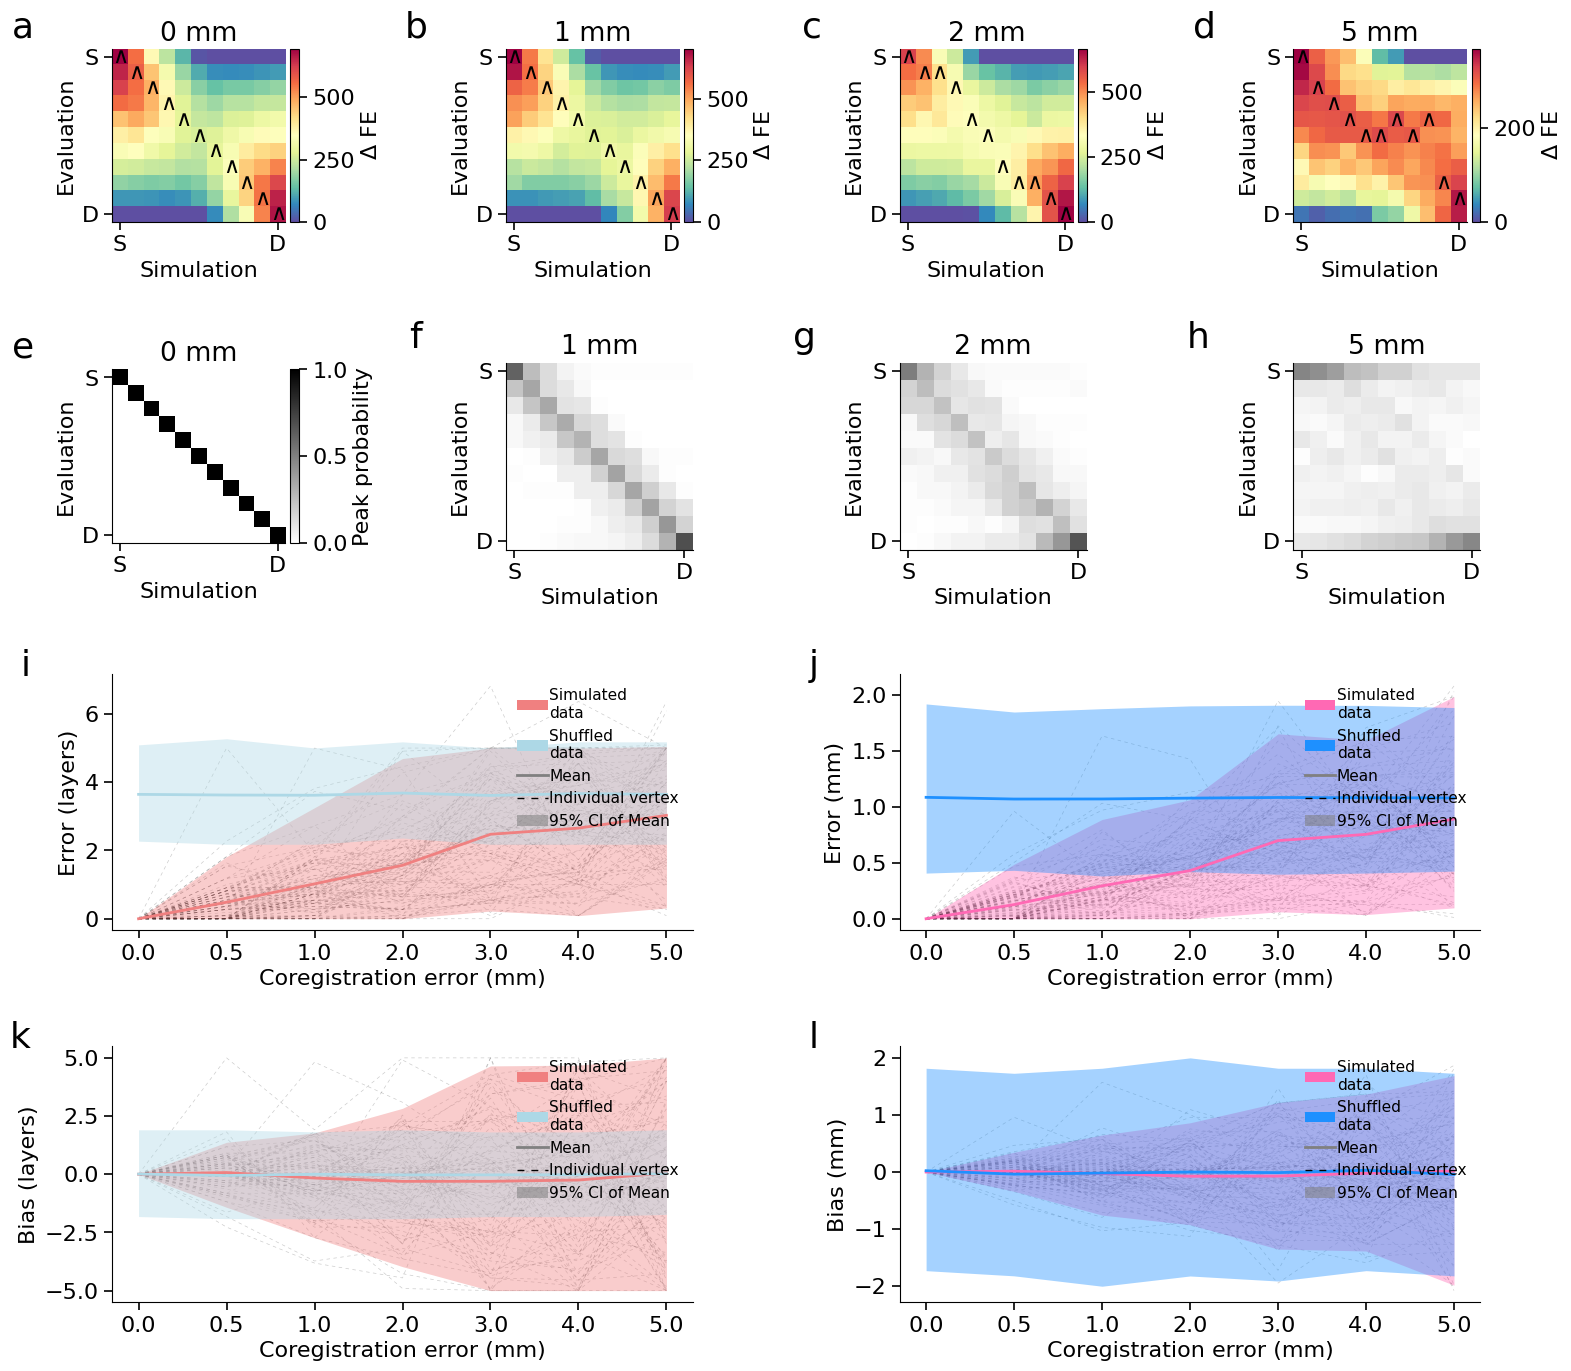

In [17]:
coregerrs_to_plot=[0, 1, 2, 5]
fig=plt.figure(figsize=(4*len(coregerrs_to_plot), 14), facecolor="white")
gs = GridSpec(4, len(coregerrs_to_plot), height_ratios=[1, 1, 1.25, 1.25])
labels=['a','b','c','d']
for err_ix, cor_err in enumerate(coregerrs_to_plot):
    ax = fig.add_subplot(gs[0,err_ix])
    ax.set_title(f"{cor_err} mm")
    m_mx = np.median(matrices_all[cor_err], axis=0)
    peaks, annot, annot_bin = find_peaks(m_mx, marker=r"$\wedge$")
    iw = plot_mx(m_mx, ax=ax, labels=True, cbar=True, cbar_label=r"$\Delta$ FE")
    annotate_mx(iw, annot)
    add_subplot_label(ax, labels[err_ix], x=-.45)

labels=['e','f','g','h']
divnorm = Normalize(vmin=0, vmax=1)
for err_ix, cor_err in enumerate(coregerrs_to_plot):
    ax = fig.add_subplot(gs[1,err_ix])
    ax.set_title(f"{cor_err} mm")
    m_mx = np.mean(annots_bin[cor_err], axis=0)
    if err_ix == 0:
        iw = plot_mx(m_mx, ax=ax, labels=True, cmap="binary", norm=divnorm, cbar=True, cbar_label=r"Peak probability")
    else:
        iw = plot_mx(m_mx, ax=ax, labels=True, cmap="binary", norm=divnorm)
    add_subplot_label(ax, labels[err_ix], x=-.45)
    
        
ax=fig.add_subplot(gs[2,0:2])
legend_handles = [
    Patch(facecolor="lightcoral", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="lightblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
]
clrs = ["lightcoral", "lightblue"]

for rix, r in enumerate([error_res, shuf_error_res]):
    ax.plot(coreg_error_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(coreg_error_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
ax.set_xticks(coreg_error_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Error (layers)")
ax.set_xlabel("Coregistration error (mm)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)
ax.plot(coreg_error_ix, error_lines, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0);
add_subplot_label(ax, 'i', x=-.14, y=1.1)


ax=fig.add_subplot(gs[2,2:4])
legend_handles = [
    Patch(facecolor="hotpink", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="dodgerblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
]
clrs = ["hotpink", "dodgerblue"]
labs = ["simulated data", "shuffled data"]
for rix, r in enumerate([error_res_mm, shuf_error_res_mm]):
    ax.plot(coreg_error_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(coreg_error_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
ax.set_xticks(coreg_error_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Error (mm)")
ax.set_xlabel("Coregistration error (mm)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)
ax.plot(coreg_error_ix, error_lines_mm, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0);
add_subplot_label(ax, 'j', x=-.14, y=1.1)


ax=fig.add_subplot(gs[3,0:2])
legend_handles = [
    Patch(facecolor="lightcoral", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="lightblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
]
clrs = ["lightcoral", "lightblue"]
labs = ["simulated data", "shuffled data"]
for rix, r in enumerate([bias_res, shuf_bias_res]):
    ax.plot(coreg_error_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(coreg_error_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
ax.set_xticks(coreg_error_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Bias (layers)")
ax.set_xlabel("Coregistration error (mm)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)
ax.plot(coreg_error_ix, bias_lines, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0);
add_subplot_label(ax, 'k', x=-.14, y=1.1)


ax=fig.add_subplot(gs[3,2:4])
legend_handles = [
    Patch(facecolor="hotpink", linewidth=0, label="Simulated\ndata"),
    Patch(facecolor="dodgerblue", linewidth=0, label="Shuffled\ndata"),
    Line2D([0], [0], color="gray", lw=2, label="Mean"),
    Line2D([0], [0], color="black", lw=1, linestyle='--', dashes=(5, 5), label="Individual vertex"),
    Patch(facecolor="gray", linewidth=0, label="95% CI of Mean", alpha=0.55),
]
clrs = ["hotpink", "dodgerblue"]
labs = ["simulated data", "shuffled data"]
for rix, r in enumerate([bias_res_mm, shuf_bias_res_mm]):
    ax.plot(coreg_error_ix, r[:,0], color=clrs[rix], lw=2)
    ax.fill_between(coreg_error_ix, r[:,1], r[:,2], color=clrs[rix], lw=0, alpha=0.4)
ax.set_xticks(coreg_error_ix)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Bias (mm)")
ax.set_xlabel("Coregistration error (mm)")
ax.legend(handles=legend_handles, fontsize="x-small", loc=1)
ax.plot(coreg_error_ix, bias_lines_mm, lw=0.5, c="black", alpha=0.2, linestyle='--', dashes=(5, 5), zorder=0);
add_subplot_label(ax, 'l', x=-.14, y=1.1)

plt.tight_layout()
plt.savefig(f"figure_03_coreg_error.pdf")